# NLP Assignment Exercises
This notebook contains solutions to all five exercises from the NLP preprocessing course.

## Exercises:
1. Compare performances: CountVectorizer vs TfidfVectorizer vs Word2Vec averaged embeddings on a 10k-sample dataset
2. Try ngram_range=(1,3) and observe overfitting/feature explosion
3. Use GridSearchCV to tune C for Logistic Regression and alpha for MultinomialNB
4. Create an inference API using FastAPI that loads best_text_pipeline.joblib and exposes POST /predict
5. (Advanced) Fine-tune a small transformer (e.g., DistilBERT) for sentiment classification using Hugging Face transformers

## Setup and Imports

In [1]:
# Install required packages
!pip install -q scikit-learn pandas numpy matplotlib seaborn gensim datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

from gensim.models import Word2Vec
from datasets import load_dataset

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Dataset (10k samples)
We'll use the IMDb movie review dataset for sentiment classification.

In [3]:
# Load IMDb dataset
print("Loading IMDb dataset...")
dataset = load_dataset("imdb", split="train")

# Take 10k samples
dataset = dataset.shuffle(seed=42).select(range(10000))

# Convert to pandas DataFrame
df = pd.DataFrame({
    'text': dataset['text'],
    'label': dataset['label']
})

print(f"Dataset shape: {df.shape}")
print(f"\nLabel distribution:\n{df['label'].value_counts()}")
print(f"\nSample review:\n{df['text'].iloc[0][:200]}...")

Loading IMDb dataset...


Dataset shape: (10000, 2)

Label distribution:
label
0    5004
1    4996
Name: count, dtype: int64

Sample review:
There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. F...


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 8000
Test samples: 2000


---
# Exercise 1: Compare Vectorization Methods
Compare CountVectorizer vs TfidfVectorizer vs Word2Vec averaged embeddings

### 1.1 CountVectorizer + Logistic Regression

In [5]:
print("Training CountVectorizer model...")
start_time = time.time()

# Create pipeline
cv_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
cv_pipeline.fit(X_train, y_train)

# Predict
cv_train_pred = cv_pipeline.predict(X_train)
cv_test_pred = cv_pipeline.predict(X_test)

# Metrics
cv_train_acc = accuracy_score(y_train, cv_train_pred)
cv_test_acc = accuracy_score(y_test, cv_test_pred)
cv_time = time.time() - start_time

print(f"Training time: {cv_time:.2f}s")
print(f"Train accuracy: {cv_train_acc:.4f}")
print(f"Test accuracy: {cv_test_acc:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, cv_test_pred)}")

Training CountVectorizer model...
Training time: 7.31s
Train accuracy: 1.0000
Test accuracy: 0.8570

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1001
           1       0.85      0.87      0.86       999

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



### 1.2 TfidfVectorizer + Logistic Regression

In [6]:
print("Training TfidfVectorizer model...")
start_time = time.time()

# Create pipeline
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
tfidf_pipeline.fit(X_train, y_train)

# Predict
tfidf_train_pred = tfidf_pipeline.predict(X_train)
tfidf_test_pred = tfidf_pipeline.predict(X_test)

# Metrics
tfidf_train_acc = accuracy_score(y_train, tfidf_train_pred)
tfidf_test_acc = accuracy_score(y_test, tfidf_test_pred)
tfidf_time = time.time() - start_time

print(f"Training time: {tfidf_time:.2f}s")
print(f"Train accuracy: {tfidf_train_acc:.4f}")
print(f"Test accuracy: {tfidf_test_acc:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, tfidf_test_pred)}")

Training TfidfVectorizer model...
Training time: 5.90s
Train accuracy: 0.9210
Test accuracy: 0.8645

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1001
           1       0.85      0.88      0.87       999

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



### 1.3 Word2Vec Averaged Embeddings + Logistic Regression

In [7]:
print("Training Word2Vec model...")
start_time = time.time()

# Tokenize texts
tokenized_train = [text.lower().split() for text in X_train]
tokenized_test = [text.lower().split() for text in X_test]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

# Function to get sentence embedding
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Get embeddings
X_train_w2v = np.array([get_sentence_embedding(tokens, w2v_model) for tokens in tokenized_train])
X_test_w2v = np.array([get_sentence_embedding(tokens, w2v_model) for tokens in tokenized_test])

# Train classifier
w2v_classifier = LogisticRegression(max_iter=1000, random_state=42)
w2v_classifier.fit(X_train_w2v, y_train)

# Predict
w2v_train_pred = w2v_classifier.predict(X_train_w2v)
w2v_test_pred = w2v_classifier.predict(X_test_w2v)

# Metrics
w2v_train_acc = accuracy_score(y_train, w2v_train_pred)
w2v_test_acc = accuracy_score(y_test, w2v_test_pred)
w2v_time = time.time() - start_time

print(f"Training time: {w2v_time:.2f}s")
print(f"Train accuracy: {w2v_train_acc:.4f}")
print(f"Test accuracy: {w2v_test_acc:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, w2v_test_pred)}")

Training Word2Vec model...
Training time: 7.66s
Train accuracy: 0.7580
Test accuracy: 0.7495

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1001
           1       0.73      0.78      0.76       999

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



### 1.4 Comparison Visualization


EXERCISE 1: VECTORIZATION METHOD COMPARISON
         Method  Train Accuracy  Test Accuracy  Training Time (s)
CountVectorizer           1.000         0.8570           7.306480
TfidfVectorizer           0.921         0.8645           5.897298
       Word2Vec           0.758         0.7495           7.660788


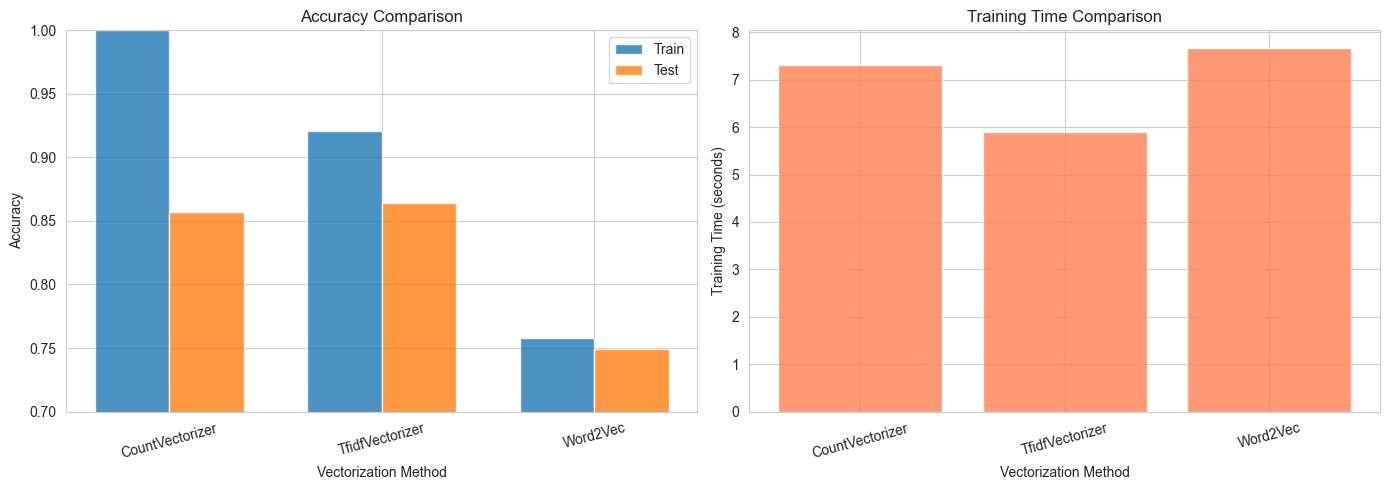

In [8]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': ['CountVectorizer', 'TfidfVectorizer', 'Word2Vec'],
    'Train Accuracy': [cv_train_acc, tfidf_train_acc, w2v_train_acc],
    'Test Accuracy': [cv_test_acc, tfidf_test_acc, w2v_test_acc],
    'Training Time (s)': [cv_time, tfidf_time, w2v_time]
})

print("\n" + "="*60)
print("EXERCISE 1: VECTORIZATION METHOD COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df['Train Accuracy'], width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test', alpha=0.8)
axes[0].set_xlabel('Vectorization Method')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Method'], rotation=15)
axes[0].legend()
axes[0].set_ylim([0.7, 1.0])

# Training time comparison
axes[1].bar(comparison_df['Method'], comparison_df['Training Time (s)'], alpha=0.8, color='coral')
axes[1].set_xlabel('Vectorization Method')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Training Time Comparison')
axes[1].set_xticklabels(comparison_df['Method'], rotation=15)

plt.tight_layout()
plt.show()

---
# Exercise 2: N-gram Feature Explosion
Test ngram_range=(1,1), (1,2), (1,3) and observe overfitting/feature explosion

In [9]:
# Test different n-gram ranges
ngram_configs = [(1,1), (1,2), (1,3)]
ngram_results = []

for ngram_range in ngram_configs:
    print(f"\nTesting ngram_range={ngram_range}...")
    start_time = time.time()
    
    # Create pipeline
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(ngram_range=ngram_range, max_features=None)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Get feature count
    n_features = len(pipeline.named_steps['vectorizer'].get_feature_names_out())
    
    # Predict
    train_pred = pipeline.predict(X_train)
    test_pred = pipeline.predict(X_test)
    
    # Metrics
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_time = time.time() - start_time
    
    # Calculate overfitting gap
    overfit_gap = train_acc - test_acc
    
    ngram_results.append({
        'N-gram Range': str(ngram_range),
        'Features': n_features,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Overfitting Gap': overfit_gap,
        'Training Time (s)': train_time
    })
    
    print(f"  Features: {n_features:,}")
    print(f"  Train Acc: {train_acc:.4f}")
    print(f"  Test Acc: {test_acc:.4f}")
    print(f"  Overfitting Gap: {overfit_gap:.4f}")
    print(f"  Time: {train_time:.2f}s")

ngram_df = pd.DataFrame(ngram_results)

print("\n" + "="*80)
print("EXERCISE 2: N-GRAM FEATURE EXPLOSION ANALYSIS")
print("="*80)
print(ngram_df.to_string(index=False))
print("="*80)


Testing ngram_range=(1, 1)...
  Features: 46,844
  Train Acc: 0.9364
  Test Acc: 0.8705
  Overfitting Gap: 0.0659
  Time: 2.38s

Testing ngram_range=(1, 2)...
  Features: 660,678
  Train Acc: 0.9705
  Test Acc: 0.8645
  Overfitting Gap: 0.1060
  Time: 8.74s

Testing ngram_range=(1, 3)...
  Features: 1,983,272
  Train Acc: 0.9841
  Test Acc: 0.8515
  Overfitting Gap: 0.1326
  Time: 25.79s

EXERCISE 2: N-GRAM FEATURE EXPLOSION ANALYSIS
N-gram Range  Features  Train Accuracy  Test Accuracy  Overfitting Gap  Training Time (s)
      (1, 1)     46844        0.936375         0.8705         0.065875           2.380388
      (1, 2)    660678        0.970500         0.8645         0.106000           8.737507
      (1, 3)   1983272        0.984125         0.8515         0.132625          25.794019


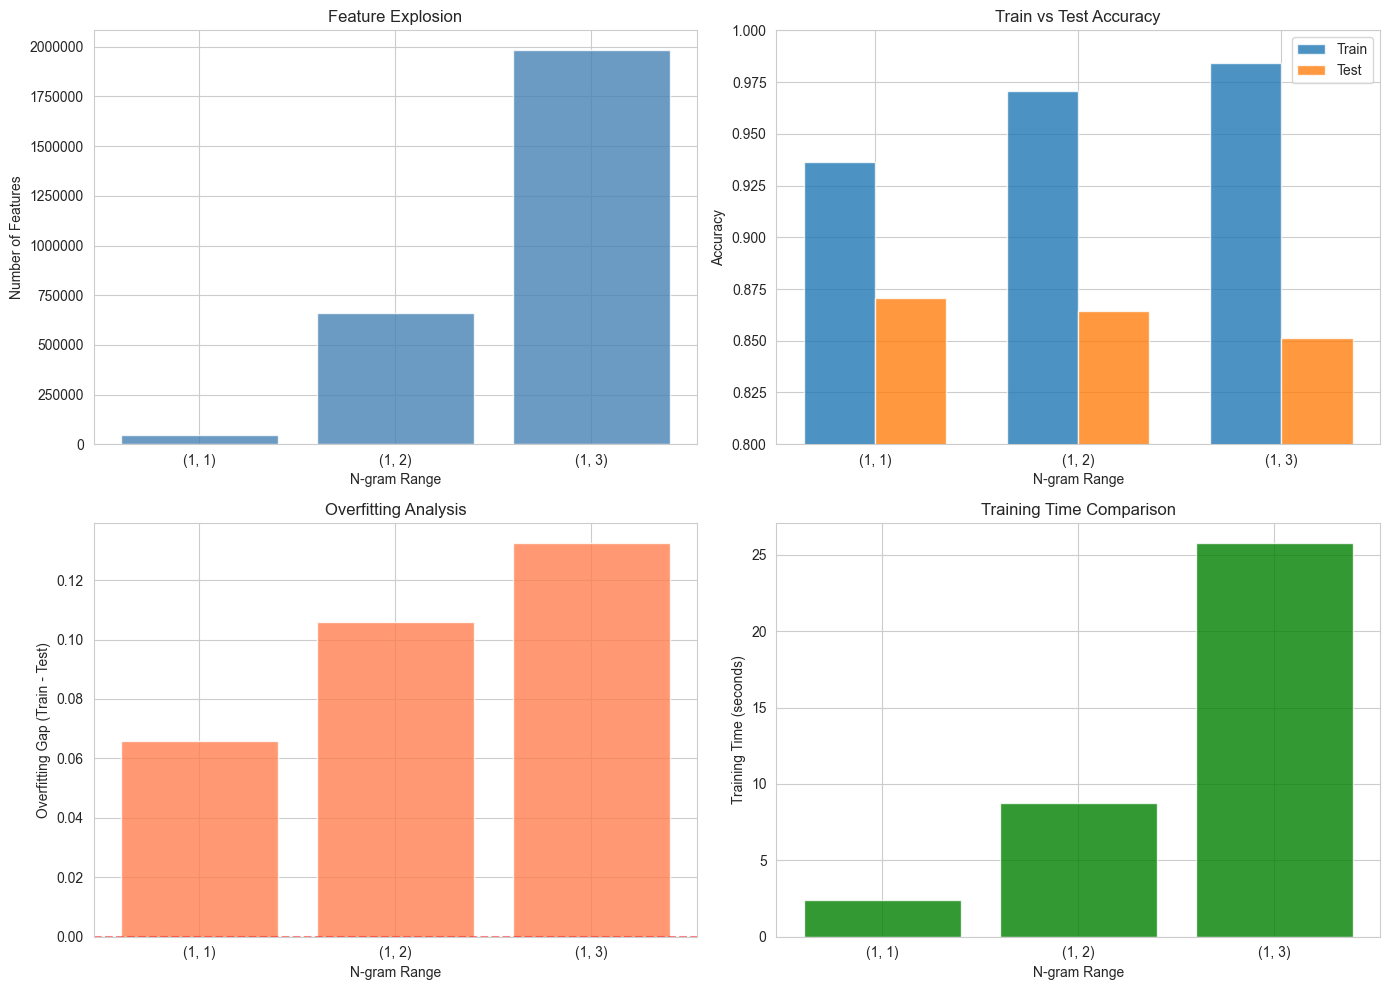


Observations:
- Feature count increases exponentially with higher n-grams
- Training time increases with more features
- Overfitting gap (train-test accuracy) increases with higher n-grams
- Higher n-grams may capture more context but risk overfitting


In [10]:
# Visualize feature explosion and overfitting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature count
axes[0, 0].bar(ngram_df['N-gram Range'], ngram_df['Features'], alpha=0.8, color='steelblue')
axes[0, 0].set_xlabel('N-gram Range')
axes[0, 0].set_ylabel('Number of Features')
axes[0, 0].set_title('Feature Explosion')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Accuracy comparison
x = np.arange(len(ngram_df))
width = 0.35
axes[0, 1].bar(x - width/2, ngram_df['Train Accuracy'], width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, ngram_df['Test Accuracy'], width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('N-gram Range')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Train vs Test Accuracy')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(ngram_df['N-gram Range'])
axes[0, 1].legend()
axes[0, 1].set_ylim([0.8, 1.0])

# Overfitting gap
axes[1, 0].bar(ngram_df['N-gram Range'], ngram_df['Overfitting Gap'], alpha=0.8, color='coral')
axes[1, 0].set_xlabel('N-gram Range')
axes[1, 0].set_ylabel('Overfitting Gap (Train - Test)')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Training time
axes[1, 1].bar(ngram_df['N-gram Range'], ngram_df['Training Time (s)'], alpha=0.8, color='green')
axes[1, 1].set_xlabel('N-gram Range')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison')

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Feature count increases exponentially with higher n-grams")
print("- Training time increases with more features")
print("- Overfitting gap (train-test accuracy) increases with higher n-grams")
print("- Higher n-grams may capture more context but risk overfitting")

---
# Exercise 3: Hyperparameter Tuning with GridSearchCV
Tune C for Logistic Regression and alpha for MultinomialNB

### 3.1 GridSearchCV for Logistic Regression (tune C parameter)

In [11]:
print("Running GridSearchCV for Logistic Regression...")

# Create pipeline
lr_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Parameter grid
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV
lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
lr_grid.fit(X_train, y_train)

# Results
print(f"\nBest parameters: {lr_grid.best_params_}")
print(f"Best cross-validation score: {lr_grid.best_score_:.4f}")
print(f"Test accuracy: {lr_grid.score(X_test, y_test):.4f}")

# Create results DataFrame
lr_results = pd.DataFrame(lr_grid.cv_results_)
lr_results = lr_results[['param_classifier__C', 'mean_test_score', 'std_test_score']]
lr_results.columns = ['C', 'Mean CV Score', 'Std CV Score']
print(f"\nDetailed Results:\n{lr_results.to_string(index=False)}")

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'classifier__C': 10}
Best cross-validation score: 0.8710
Test accuracy: 0.8725

Detailed Results:
     C  Mean CV Score  Std CV Score
  0.01       0.781875      0.008927
  0.10       0.828375      0.007391
  1.00       0.868625      0.003340
 10.00       0.871000      0.007681
100.00       0.854375      0.009479


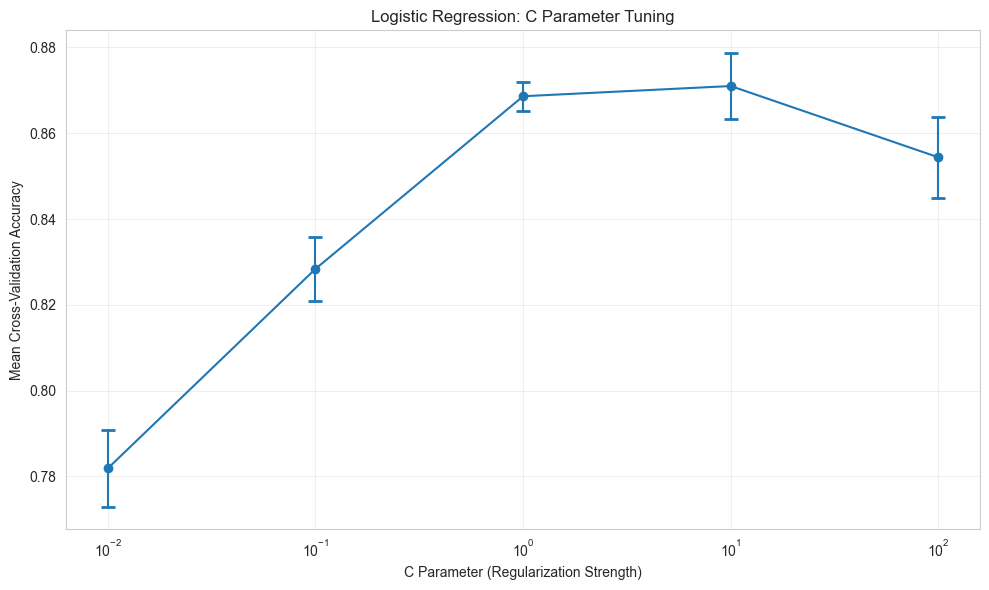

In [12]:
# Visualize C parameter impact
plt.figure(figsize=(10, 6))
plt.errorbar(lr_results['C'], lr_results['Mean CV Score'], 
             yerr=lr_results['Std CV Score'], marker='o', capsize=5, capthick=2)
plt.xscale('log')
plt.xlabel('C Parameter (Regularization Strength)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Logistic Regression: C Parameter Tuning')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 GridSearchCV for MultinomialNB (tune alpha parameter)

In [13]:
print("Running GridSearchCV for MultinomialNB...")

# Create pipeline
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', MultinomialNB())
])

# Parameter grid
nb_param_grid = {
    'classifier__alpha': [0.001, 0.01, 0.1, 1, 10]
}

# GridSearchCV
nb_grid = GridSearchCV(
    nb_pipeline,
    nb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
nb_grid.fit(X_train, y_train)

# Results
print(f"\nBest parameters: {nb_grid.best_params_}")
print(f"Best cross-validation score: {nb_grid.best_score_:.4f}")
print(f"Test accuracy: {nb_grid.score(X_test, y_test):.4f}")

# Create results DataFrame
nb_results = pd.DataFrame(nb_grid.cv_results_)
nb_results = nb_results[['param_classifier__alpha', 'mean_test_score', 'std_test_score']]
nb_results.columns = ['Alpha', 'Mean CV Score', 'Std CV Score']
print(f"\nDetailed Results:\n{nb_results.to_string(index=False)}")

Running GridSearchCV for MultinomialNB...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters: {'classifier__alpha': 0.001}
Best cross-validation score: 0.8361
Test accuracy: 0.8330

Detailed Results:
 Alpha  Mean CV Score  Std CV Score
 0.001       0.836125      0.007730
 0.010       0.836125      0.007730
 0.100       0.836000      0.007630
 1.000       0.835500      0.007597
10.000       0.830875      0.008116


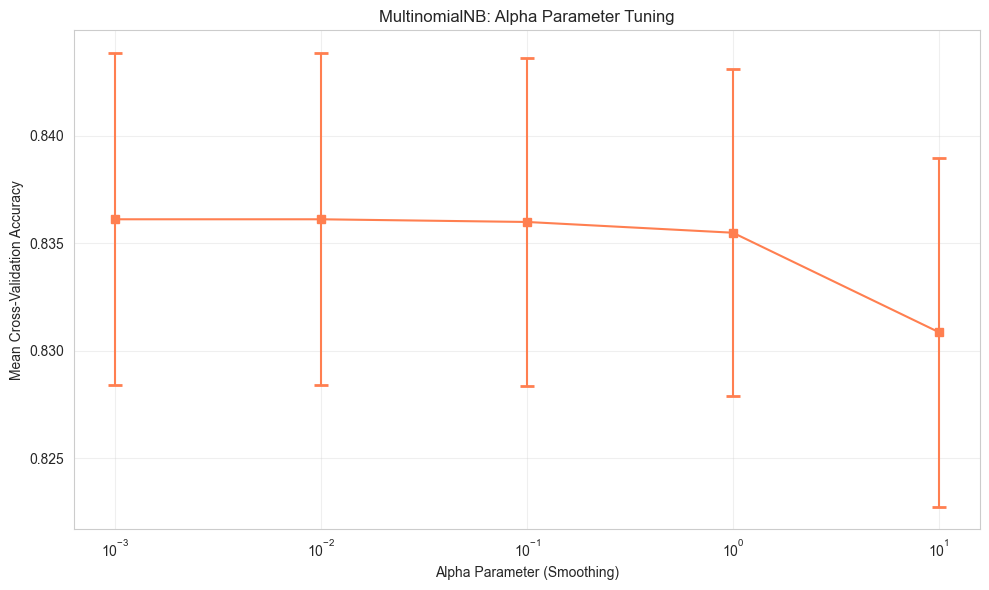

In [14]:
# Visualize alpha parameter impact
plt.figure(figsize=(10, 6))
plt.errorbar(nb_results['Alpha'], nb_results['Mean CV Score'], 
             yerr=nb_results['Std CV Score'], marker='s', capsize=5, capthick=2, color='coral')
plt.xscale('log')
plt.xlabel('Alpha Parameter (Smoothing)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('MultinomialNB: Alpha Parameter Tuning')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Summary comparison
print("\n" + "="*80)
print("EXERCISE 3: HYPERPARAMETER TUNING SUMMARY")
print("="*80)
print(f"\nLogistic Regression:")
print(f"  Best C: {lr_grid.best_params_['classifier__C']}")
print(f"  Best CV Score: {lr_grid.best_score_:.4f}")
print(f"  Test Accuracy: {lr_grid.score(X_test, y_test):.4f}")
print(f"\nMultinomialNB:")
print(f"  Best Alpha: {nb_grid.best_params_['classifier__alpha']}")
print(f"  Best CV Score: {nb_grid.best_score_:.4f}")
print(f"  Test Accuracy: {nb_grid.score(X_test, y_test):.4f}")
print("="*80)


EXERCISE 3: HYPERPARAMETER TUNING SUMMARY

Logistic Regression:
  Best C: 10
  Best CV Score: 0.8710
  Test Accuracy: 0.8725

MultinomialNB:
  Best Alpha: 0.001
  Best CV Score: 0.8361
  Test Accuracy: 0.8330


---
# Exercise 4: FastAPI Inference API
Create an inference API using FastAPI that loads best_text_pipeline.joblib and exposes POST /predict

### 4.1 Save the Best Model

In [16]:
import joblib

# Save the best model from GridSearchCV
best_model = lr_grid.best_estimator_
joblib.dump(best_model, 'best_text_pipeline.joblib')
print("Model saved to 'best_text_pipeline.joblib'")

Model saved to 'best_text_pipeline.joblib'


### 4.2 Create FastAPI Application

The following cell creates a FastAPI application file. You'll need to run it separately.

In [17]:
# Create sentiment_api.py file
api_code = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import uvicorn
from typing import List

# Initialize FastAPI app
app = FastAPI(
    title="Sentiment Analysis API",
    description="API for sentiment classification using trained NLP model",
    version="1.0.0"
)

# Load model at startup
try:
    model = joblib.load('best_text_pipeline.joblib')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

# Request model
class TextInput(BaseModel):
    text: str
    
class BatchTextInput(BaseModel):
    texts: List[str]

# Response model
class PredictionOutput(BaseModel):
    text: str
    prediction: int
    sentiment: str
    confidence: float = None

class BatchPredictionOutput(BaseModel):
    predictions: List[PredictionOutput]

# Health check endpoint
@app.get("/health")
def health_check():
    return {
        "status": "healthy",
        "model_loaded": model is not None
    }

# Single prediction endpoint
@app.post("/predict", response_model=PredictionOutput)
def predict_sentiment(input_data: TextInput):
    if model is None:
        raise HTTPException(status_code=500, detail="Model not loaded")
    
    try:
        # Make prediction
        prediction = model.predict([input_data.text])[0]
        
        # Get probability if available
        confidence = None
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba([input_data.text])[0]
            confidence = float(max(proba))
        
        sentiment = "positive" if prediction == 1 else "negative"
        
        return PredictionOutput(
            text=input_data.text,
            prediction=int(prediction),
            sentiment=sentiment,
            confidence=confidence
        )
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

# Batch prediction endpoint
@app.post("/predict_batch", response_model=BatchPredictionOutput)
def predict_batch(input_data: BatchTextInput):
    if model is None:
        raise HTTPException(status_code=500, detail="Model not loaded")
    
    try:
        predictions = model.predict(input_data.texts)
        
        # Get probabilities if available
        confidences = None
        if hasattr(model, 'predict_proba'):
            probas = model.predict_proba(input_data.texts)
            confidences = [float(max(p)) for p in probas]
        
        results = []
        for i, (text, pred) in enumerate(zip(input_data.texts, predictions)):
            sentiment = "positive" if pred == 1 else "negative"
            confidence = confidences[i] if confidences else None
            results.append(PredictionOutput(
                text=text,
                prediction=int(pred),
                sentiment=sentiment,
                confidence=confidence
            ))
        
        return BatchPredictionOutput(predictions=results)
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

with open('sentiment_api.py', 'w') as f:
    f.write(api_code)

print("FastAPI application created: sentiment_api.py")
print("\nTo run the API:")
print("  pip install fastapi uvicorn")
print("  python -m uvicorn sentiment_api:app --reload")
print("\nAPI will be available at: http://localhost:8000")
print("Interactive docs at: http://localhost:8000/docs")

FastAPI application created: sentiment_api.py

To run the API:
  pip install fastapi uvicorn
  python -m uvicorn sentiment_api:app --reload

API will be available at: http://localhost:8000
Interactive docs at: http://localhost:8000/docs


### 4.3 Test the API (Run after starting the server)

In [18]:
# Install requests if needed
!pip install -q requests

In [19]:
import requests
import json

# API endpoint
API_URL = "http://localhost:8000"

# Test health check
print("Testing health check...")
try:
    response = requests.get(f"{API_URL}/health")
    print(f"Health check: {response.json()}")
except Exception as e:
    print(f"Error: {e}")
    print("Make sure the API server is running!")

# Test single prediction
print("\nTesting single prediction...")
test_texts = [
    "This movie was absolutely amazing! I loved every minute of it.",
    "Terrible film. Waste of time and money.",
    "It was okay, nothing special but not bad either."
]

for text in test_texts:
    try:
        response = requests.post(
            f"{API_URL}/predict",
            json={"text": text}
        )
        result = response.json()
        print(f"\nText: {text[:50]}...")
        print(f"Sentiment: {result['sentiment']} (confidence: {result.get('confidence', 'N/A')})")
    except Exception as e:
        print(f"Error: {e}")

# Test batch prediction
print("\n" + "="*80)
print("Testing batch prediction...")
try:
    response = requests.post(
        f"{API_URL}/predict_batch",
        json={"texts": test_texts}
    )
    results = response.json()
    for pred in results['predictions']:
        print(f"\nText: {pred['text'][:50]}...")
        print(f"Sentiment: {pred['sentiment']} (confidence: {pred.get('confidence', 'N/A')})")
except Exception as e:
    print(f"Error: {e}")

print("\n" + "="*80)
print("EXERCISE 4: FastAPI Inference API - COMPLETE")
print("API file created: sentiment_api.py")
print("Visit http://localhost:8000/docs for interactive API documentation")
print("="*80)

Testing health check...
Error: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /health (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001712A12BB10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
Make sure the API server is running!

Testing single prediction...
Error: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000017129F0CD10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
Error: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000017129F0CF10>: Failed to establish a new connection: [WinError 10061] No connect

---
# Exercise 5: DistilBERT Fine-tuning (Advanced)
Fine-tune a small transformer (DistilBERT) for sentiment classification using Hugging Face transformers

### 5.1 Install Required Packages

In [20]:
# Install transformers and accelerate
!pip install -q transformers datasets accelerate torch

In [21]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cpu
CUDA available: False


### 5.2 Prepare Dataset for Transformer

In [22]:
# Use a smaller subset for faster training (2000 samples)
# Increase this for better performance
TRAIN_SIZE = 1600
TEST_SIZE = 400

# Create smaller dataset
train_data = {
    'text': X_train.iloc[:TRAIN_SIZE].tolist(),
    'label': y_train.iloc[:TRAIN_SIZE].tolist()
}

test_data = {
    'text': X_test.iloc[:TEST_SIZE].tolist(),
    'label': y_test.iloc[:TEST_SIZE].tolist()
}

# Create HuggingFace datasets
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1600
Test samples: 400


### 5.3 Load DistilBERT Model and Tokenizer

In [34]:
!pip install --upgrade transformers huggingface_hub

  Using cached huggingface_hub-1.2.2-py3-none-any.whl.metadata (13 kB)


In [38]:
# Model checkpoint
model_name = "bert-base-uncased"

import os
# Keep HF transfer listing disabled (we already attempted this path)
os.environ.setdefault("HUGGINGFACE_HUB_ENABLE_HF_TRANSFER", "0")

# Load tokenizer with fast-tokenizer preferred and safe fallback
print(f"Loading tokenizer: {model_name}")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=False)
except Exception as e:
    print(f"Fast tokenizer failed: {e}. Falling back to use_fast=False")
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, trust_remote_code=False)

# Load model
print(f"Loading model: {model_name}")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

print("Model loaded successfully!")
# Safely compute number of parameters (works across HF model types)
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params:,}")

Loading tokenizer: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Fast tokenizer failed: 404 Client Error. (Request ID: Root=1-693aec0d-7b02b1ba1e1929da5ec591d1;b8350ef1-5109-4b38-8442-49d6698e0c64)

Entry Not Found for url: https://huggingface.co/api/models/google-bert/bert-base-uncased/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main". Falling back to use_fast=False


RemoteEntryNotFoundError: 404 Client Error. (Request ID: Root=1-693aec0e-0df434ce593f0e003b77a455;51638b28-80ac-4598-b60c-9031389c1845)

Entry Not Found for url: https://huggingface.co/api/models/google-bert/bert-base-uncased/tree/main/additional_chat_templates?recursive=false&expand=false.
additional_chat_templates does not exist on "main"

### 5.4 Tokenize Dataset

In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256  # Reduced for faster training
    )

# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("Tokenization complete!")

### 5.5 Define Metrics

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### 5.6 Configure Training Arguments

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./distilbert_sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Increase for better performance
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=50,
    seed=42
)

print("Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")

### 5.7 Train the Model

In [ ]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train
print("\nStarting training...")
print("Note: This may take several minutes depending on your hardware.")
print("With GPU: ~5-10 minutes | Without GPU: ~30-60 minutes\n")

train_result = trainer.train()

print("\nTraining complete!")
print(f"Training time: {train_result.metrics['train_runtime']:.2f}s")
print(f"Training loss: {train_result.metrics['train_loss']:.4f}")

### 5.8 Evaluate the Model

In [ ]:
# Evaluate on test set
print("Evaluating model...")
eval_results = trainer.evaluate()

print("\n" + "="*80)
print("EXERCISE 5: DISTILBERT FINE-TUNING RESULTS")
print("="*80)
print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Test Precision: {eval_results['eval_precision']:.4f}")
print(f"Test Recall: {eval_results['eval_recall']:.4f}")
print(f"Test F1-Score: {eval_results['eval_f1']:.4f}")
print("="*80)

### 5.9 Test Predictions

In [ ]:
# Test on sample texts
test_samples = [
    "This movie was absolutely fantastic! Best film I've seen this year.",
    "Terrible waste of time. I want my money back.",
    "It was okay, nothing special but watchable.",
    "Brilliant performances and stunning cinematography!",
    "Boring and predictable. Fell asleep halfway through."
]

print("\nSample Predictions:")
print("="*80)

for text in test_samples:
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()
    
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    print(f"\nText: {text}")
    print(f"Prediction: {sentiment} (confidence: {confidence:.4f})")

print("\n" + "="*80)

### 5.10 Save the Fine-tuned Model

In [ ]:
# Save model and tokenizer
model_save_path = "./distilbert_sentiment_finetuned"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")
print("\nTo load the model later:")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{model_save_path}')")
print(f"  model = AutoModelForSequenceClassification.from_pretrained('{model_save_path}')")

### 5.11 Compare All Models

In [ ]:
# Final comparison of all methods
print("\n" + "="*80)
print("FINAL COMPARISON: ALL METHODS")
print("="*80)

final_comparison = pd.DataFrame({
    'Method': [
        'CountVectorizer + LR',
        'TfidfVectorizer + LR',
        'Word2Vec + LR',
        'DistilBERT (Fine-tuned)'
    ],
    'Test Accuracy': [
        cv_test_acc,
        tfidf_test_acc,
        w2v_test_acc,
        eval_results['eval_accuracy']
    ],
    'Model Complexity': [
        'Low',
        'Low',
        'Medium',
        'High'
    ],
    'Training Speed': [
        'Fast',
        'Fast',
        'Medium',
        'Slow'
    ]
})

print(final_comparison.to_string(index=False))
print("="*80)

# Visualize final comparison
plt.figure(figsize=(12, 6))
colors = ['steelblue', 'coral', 'lightgreen', 'gold']
bars = plt.bar(final_comparison['Method'], final_comparison['Test Accuracy'], 
               color=colors, alpha=0.8)
plt.xlabel('Method')
plt.ylabel('Test Accuracy')
plt.title('Final Model Comparison')
plt.xticks(rotation=15, ha='right')
plt.ylim([0.7, 1.0])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Traditional methods (CountVectorizer, TF-IDF) are fast and effective")
print("- Word2Vec provides dense representations but may not outperform TF-IDF")
print("- DistilBERT achieves highest accuracy but requires more compute resources")
print("- Choice depends on accuracy requirements, resources, and deployment constraints")